### Data Preparation

In [4]:
#Preparations
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re
import warnings


#Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format',  '{:,.2f}'.format)
pd.set_option('display.precision', 2)

#import the dataset
df = pd.read_csv('metadata.csv', low_memory=False, thousands=',')

# Fix some entires
df['Domestic Box Office'] = df['Domestic Box Office'].fillna(0)
df['International Box Office'] = df['International Box Office'].fillna(0)
df['Worldwide Box Office'] = df['Worldwide Box Office'].fillna(0)

df['Revenue'] = np.maximum(df['Domestic Box Office'] + df['International Box Office'], df['Worldwide Box Office'])
for index, row in df.iterrows():
    if pd.isna(row['Leading Cast']):
        df.at[index, 'Leading Cast'] = df.at[index, 'Lead Ensemble Members']
        
        # Subsetting rows with both Budget and Revenue
df_sub = df.loc[(df['Revenue'] != 0) & (df['Budget'] != 0)].copy()
# Compute ROI
df_sub['ROI'] = (df_sub['Revenue']-df_sub['Budget'])/df_sub['Budget']*100

In [5]:
mon = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
dom_rel_month = pd.Series([])
for index, row in df_sub['Domestic Release'].to_frame().iterrows():
    d = ""
    if not pd.isna(row[0]):
        d = re.findall(r"([a-zA-Z]+)", row[0])
        if d != [] and d[0] in mon:
            t = d[0]
        else:
            t = np.nan
    else: 
        t = np.nan
    with warnings.catch_warnings():
        warnings.simplefilter(action = 'ignore', category = FutureWarning)
        dom_rel_month = dom_rel_month.append(pd.Series(data = t))

C:\Users\kongw\AppData\Local\Temp\ipykernel_21032\3740225237.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dom_rel_month = pd.Series([])


In [6]:
int_rel_month = pd.Series([])
for index, row in df_sub['International Release'].to_frame().iterrows():
    d = ""
    if not pd.isna(row[0]):
        d = re.findall(r"([a-zA-Z]+)", row[0])
        if d != [] and d[0] in mon:
            t = d[0]
        else:
            t = np.nan
    else: 
        t = np.nan
    with warnings.catch_warnings():
        warnings.simplefilter(action = 'ignore', category = FutureWarning)
        int_rel_month = int_rel_month.append(pd.Series(data = t))

C:\Users\kongw\AppData\Local\Temp\ipykernel_21032\3402644605.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  int_rel_month = pd.Series([])


In [7]:
df_sub['int_rel_month'] = int_rel_month.to_list()
df_sub['dom_rel_month'] = dom_rel_month.to_list()
df_sub['Year'] = ''
df_sub['Month'] = ''

from datetime import datetime

for index, row in df_sub.iterrows():
    if pd.isna(row['Dom Year']):
        df_sub.at[index, 'Year'] = row['Int Year']
        df_sub.at[index, 'Month'] = row['int_rel_month']
    else: 
        # dom year not na
        if pd.isna(row['Int Year']):
            df_sub.at[index, 'Year'] = row['Dom Year']
            df_sub.at[index, 'Month'] = row['dom_rel_month']
        else:
            #both year not na
            if row['Dom Year'] == row['Int Year']:
                df_sub.at[index, 'Year'] = row['Dom Year']
                # month
                if pd.isna(row['int_rel_month']):
                    df_sub.at[index, 'Month'] = row['dom_rel_month']
                elif pd.isna(row['dom_rel_month']):
                    df_sub.at[index, 'Month'] = row['int_rel_month']
                else:
                    #compare month
                    i = datetime.strptime(row['int_rel_month'], '%B').month
                    d = datetime.strptime(row['dom_rel_month'], '%B').month
                    if i <= d:
                        df_sub.at[index, 'Month'] = row['int_rel_month']
                    else:
                        df_sub.at[index, 'Month'] = row['dom_rel_month']
            elif row['Dom Year'] < row['Int Year']:
                df_sub.at[index, 'Year'] = row['Dom Year']
                df_sub.at[index, 'Month'] = row['dom_rel_month']
            else: 
                df_sub.at[index, 'Year'] = row['Int Year']
                df_sub.at[index, 'Month'] = row['int_rel_month']

### Create Features

In [8]:
df_sub['is_Franchise'] = np.where(pd.isna(df_sub['Franchise']), False, True)

In [9]:
dataset = df_sub[['moviename', 'Budget', 'Revenue', 'ROI', 'Year', 'Month',
            'Rating', 'Franchise', 'is_Franchise', 'Keywords', 'Genre', 'Production Method',
            'Creative Type', 'Production/Financing Companies', 'Leading Cast', 'Director']].copy()
dataset = dataset[~dataset['Year'].isna()]
dataset = dataset.loc[dataset['ROI'] < 50000]
dataset = dataset.loc[dataset['ROI'] > -95]

### Descriptive

#### Cast

In [10]:
import ast
dataset['Leading Cast'] = dataset['Leading Cast'].fillna('[]').apply(ast.literal_eval)
cast = pd.DataFrame(columns = ['name', 'number', 'Total Budget', 'Total Revenue'])
# cast.head(1)
for index, row in dataset.iterrows():
    lead = row['Leading Cast']
    if lead != []:
        for name in lead:
            if name in cast['name'].values:
                rownum = np.where(cast['name'] == name)[0][0]
                cast.at[rownum, 'number'] = cast.at[rownum, 'number'] + 1
                cast.at[rownum, 'Total Budget'] = cast.at[rownum, 'Total Budget'] + row['Budget']
                cast.at[rownum, 'Total Revenue'] = cast.at[rownum, 'Total Revenue'] + row['Revenue']
            else: 
                cast.loc[len(cast)] = [name, 1, row['Budget'], row['Revenue']]
cast['Average Budget'] = cast['Total Budget']/cast['number']
cast['Average Revenue'] = cast['Total Revenue']/cast['number']
cast = cast.loc[cast['number'] >= 5].copy()
top20_ave_rev = cast.sort_values(by = ['Average Revenue'], ascending = False)['name'].head(20).reset_index(drop=True)
top20_tot_rev = cast.sort_values(by = ['Total Revenue'], ascending = False)['name'].head(20).reset_index(drop=True)
top20_ave_bud = cast.sort_values(by = ['Average Budget'], ascending = False)['name'].head(20).reset_index(drop=True)
top20_tot_bud = cast.sort_values(by = ['Total Budget'], ascending = False)['name'].head(20).reset_index(drop=True)
top20_num = cast.sort_values(by = ['number'], ascending = False)['name'].head(20).reset_index(drop=True)
starlist = top20_num.tolist() + top20_ave_rev.tolist() + \
    top20_tot_rev.tolist() + top20_ave_bud.tolist() + top20_tot_bud.tolist()
starlist = list(set(starlist))

# print("We have ", len(starlist), " stars")

dataset['has_star_actor'] = False
for index, row in dataset.iterrows():
    lead = row['Leading Cast']
    if lead != []:
        for name in lead:
            if name in starlist:
                dataset.at[index, 'has_star_actor'] = True
                break

#### Director

In [11]:
dataset['Director'] = dataset['Director'].fillna('[]').apply(ast.literal_eval)
director = pd.DataFrame(columns = ['name', 'number', 'Total Budget', 'Total Revenue'])
for index, row in dataset.iterrows():
    lead = row['Director']
    if lead != []:
        for name in lead:
            if name in director['name'].values:
                rownum = np.where(director['name'] == name)[0][0]
                director.at[rownum, 'number'] = director.at[rownum, 'number'] + 1
                director.at[rownum, 'Total Budget'] = director.at[rownum, 'Total Budget'] + row['Budget']
                director.at[rownum, 'Total Revenue'] = director.at[rownum, 'Total Revenue'] + row['Revenue']
            else: 
                director.loc[len(director)] = [name, 1, row['Budget'], row['Revenue']]
director['Average Budget'] = director['Total Budget']/director['number']
director['Average Revenue'] = director['Total Revenue']/director['number']
director = director.loc[director['number'] >= 5].copy()
top20_ave_rev = director.sort_values(by = ['Average Revenue'], ascending = False)['name'].head(20).reset_index(drop=True)
top20_tot_rev = director.sort_values(by = ['Total Revenue'], ascending = False)['name'].head(20).reset_index(drop=True)
top20_ave_bud = director.sort_values(by = ['Average Budget'], ascending = False)['name'].head(20).reset_index(drop=True)
top20_tot_bud = director.sort_values(by = ['Total Budget'], ascending = False)['name'].head(20).reset_index(drop=True)
top20_num = director.sort_values(by = ['number'], ascending = False)['name'].head(20).reset_index(drop=True)

starlist = top20_num.tolist() + top20_ave_rev.tolist() + \
    top20_tot_rev.tolist() + top20_ave_bud.tolist() + top20_tot_bud.tolist()
starlist = list(set(starlist))
print("We have ", len(starlist), " star directors")

dataset['has_star_director'] = False
for index, row in dataset.iterrows():
    lead = row['Director']
    if lead != []:
        for name in lead:
            if name in starlist:
                dataset.at[index, 'has_star_director'] = True
                break

We have  47  star directors


#### Timely trend

In [213]:
genrelist = list(dataset['Genre'].value_counts().index[0:11])

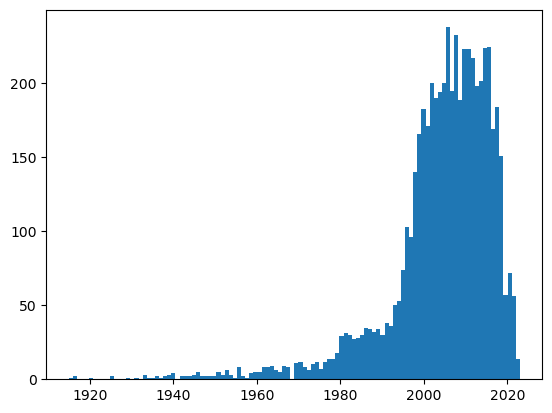

In [237]:
plt.hist(dataset['Year'].astype('int'), bins = 110)
plt.show()

### Consider every 10 years a period

In [224]:
year_genre_bynumber = pd.DataFrame()
year_genre_bysumBud = pd.DataFrame()
year_genre_bysumRev = pd.DataFrame()
year_genre_bymeanBud = pd.DataFrame()
year_genre_bymeanRev = pd.DataFrame()
year_genre_bymeanROI = pd.DataFrame()

for y in range(1980, 2024, 1):
    subset = dataset.loc[dataset['Year'] <= y].copy()
    subset = subset.loc[subset['Year'] > y - 10].copy()
    res = pd.DataFrame(columns = ['genre', 'number', 'sumBud', 'sumRev', 
                            'meanBud', 'meanRev', 'meanROI'])
    for g in genrelist:
        t = subset.loc[subset['Genre'] == g].copy()
        number = t.shape[0]
        sumBud = sum(t['Budget'])
        sumRev = sum(t['Revenue'])
        meanBud = 0
        meanRev = 0
        meanROI = -100
        if number != 0:
            meanBud = sumBud/number
            meanRev = sumRev/number
            meanROI = t['ROI'].mean()
        res.loc[len(res)] = [g, number, sumBud, sumRev, meanBud, meanRev, meanROI]
    # res['number'] = res['number'].rank(ascending = False)
    # res['sumBud'] = res['sumBud'].rank(ascending = False)
    # res['sumRev'] = res['sumRev'].rank(ascending = False)
    # res['meanBud'] = res['meanBud'].rank(ascending = False)
    # res['meanRev'] = res['meanRev'].rank(ascending = False)
    # res['meanROI'] = res['meanROI'].rank(ascending = False)
    
    year_genre_bynumber[y] = res['number']
    year_genre_bysumBud[y] = res['sumBud']
    year_genre_bysumRev[y] = res['sumRev']
    year_genre_bymeanBud[y] = res['meanBud']
    year_genre_bymeanRev[y] = res['meanRev']
    year_genre_bymeanROI[y] = res['meanROI']
    
year_genre_bynumber.index = genrelist
year_genre_bysumBud.index = genrelist
year_genre_bysumRev.index = genrelist
year_genre_bymeanBud.index = genrelist
year_genre_bymeanRev.index = genrelist
year_genre_bymeanROI.index = genrelist

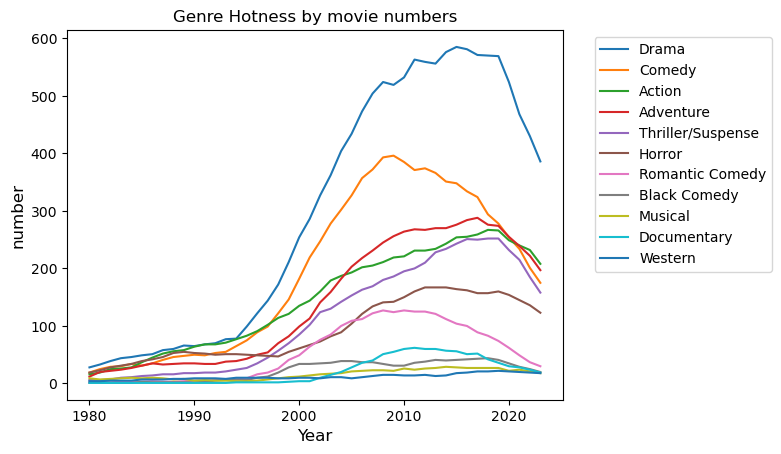

In [229]:
ax = year_genre_bynumber.T.plot()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_ylabel('number', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.set_title('Genre Hotness by movie numbers')
plt.show()

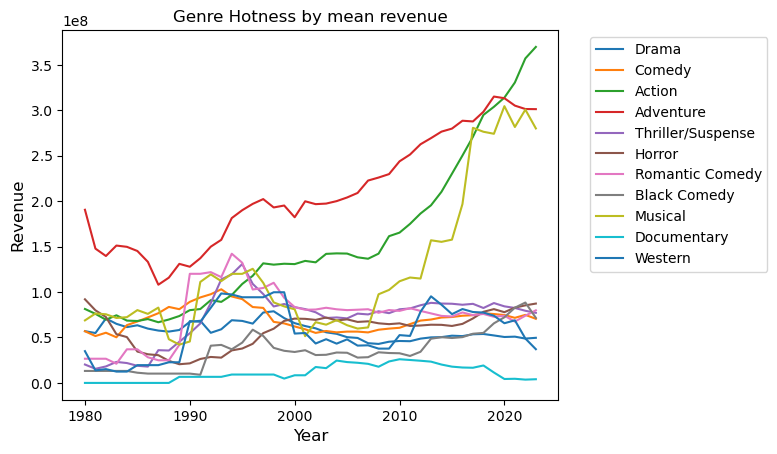

In [230]:
ax = year_genre_bymeanRev.T.plot()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_ylabel('Revenue', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.set_title('Genre Hotness by mean revenue')
plt.show()

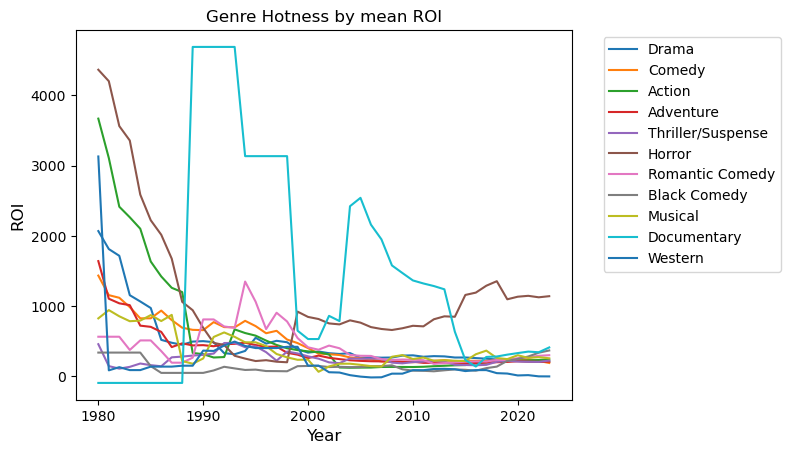

In [231]:
ax = year_genre_bymeanROI.T.plot()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_ylabel('ROI', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.set_title('Genre Hotness by mean ROI')
plt.show()

In [239]:
dataset.loc[dataset['Genre'] == "Documentary"]

,moviename,Budget,Revenue,ROI,Year,Month,Rating,Franchise,is_Franchise,Keywords,Genre,Production Method,Creative Type,Production/Financing Companies,Leading Cast,Director,has_star_actor,hit,has_star_director
136,What the #$'! Do We Know,4000000,"11,704,768.00",192.62,"2,004.00",February,Not Rated,['What the Bleep'],True,['Meaning of Life'],Documentary,Live Action,Factual,NaN,[],"[William H. Arntz, Betsy Chasse, Mark Vicente]",False,Above average,False
155,The Real Cancun,4000000,"4,188,034.00",4.70,"2,003.00",April,R,NaN,False,['Reality TV'],Documentary,Live Action,Factual,NaN,[],[Rick de Oliveira],False,Below average,False
159,Samsara,4000000,"5,966,671.00",49.17,"2,012.00",August,PG-13,NaN,False,"['Limited Dialogue', 'Avant Garde', 'Dancing',...",Documentary,Live Action,Factual,"['Magidson Films', 'Mark Magidson']",[],[Ron Fricke],False,Below average,False
291,La marche de l'empereur,3400000,"133,276,359.00","3,819.89","2,005.00",June,G,NaN,False,NaN,Documentary,Live Action,Factual,NaN,[],[],False,Super hits,False
335,Bowling for Columbine,3000000,"58,240,487.00","1,841.35","2,002.00",October,R,NaN,False,NaN,Documentary,Live Action,Factual,NaN,[],[Michael Moore],False,Super hits,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6273,Hillary’s America: The Secret History of the D...,5000000,"13,099,931.00",162.00,"2,016.00",July,PG-13,NaN,False,"['Agitprop', 'Directing Yourself', 'Political'...",Documentary,Live Action,Factual,"['Quality Flix', 'D’Souza Media']",[],[Dinesh D'Souza],False,Above average,False
6297,Fahrenheit 11/9,5000000,"6,653,715.00",33.07,"2,018.00",September,R,NaN,False,"['Agitprop', 'Political', 'Politicians', 'Arch...",Documentary,Live Action,Factual,"['State Run Films', 'Briarcliff Entertainment'...",[],[Michael Moore],False,Below average,False
6299,Sea Rex 3D: Journey to a Prehistoric World,5000000,"16,515,203.00",230.30,"2,010.00",May,Not Rated,NaN,False,['3-D'],Documentary,Animation/Live Action,Factual,['3D Entertainment Films'],[],[],False,Above average,False
6334,American Teen,5000000,"989,319.00",-80.21,"2,008.00",July,PG-13,NaN,False,NaN,Documentary,Live Action,Factual,NaN,[],[],False,Loss,False


### Model

In [29]:
dataset['hit'] = ''
for index, row in dataset.iterrows():
    if row['ROI'] <= 0:
        dataset.at[index, 'hit'] = 'Loss'
    elif row['ROI'] > 0 and row['ROI'] <= 106.71:
        dataset.at[index, 'hit'] = 'Below average'
    elif row['ROI'] > 106.71 and row['ROI'] <= 320.26:
        dataset.at[index, 'hit'] = 'Above average'
    elif row['ROI'] > 320.26 and row['ROI'] <= 1000:
        dataset.at[index, 'hit'] = 'Hits'
    elif row['ROI'] > 1000:
        dataset.at[index, 'hit'] = 'Super hits'      

In [30]:
X = dataset[['Budget', 'Year', 'Month',
       'Rating', 'is_Franchise', 'Genre', 'Production Method',
       'Creative Type', 'has_star_actor', 'has_star_director']].copy()
X["Month"] = X["Month"].astype("category")
X["Rating"] = X["Rating"].astype("category")
X["is_Franchise"] = X["is_Franchise"].astype("category")
X["Genre"] = X["Genre"].astype("category")
X["Production Method"] = X["Production Method"].astype("category")
X["Creative Type"] = X["Creative Type"].astype("category")
X["Year"] = X["Year"].astype('Int64')

X["has_star_actor"] = X["has_star_actor"].astype("category")
X["has_star_director"] = X["has_star_director"].astype("category")

accuracy score:  0.35695067264573993


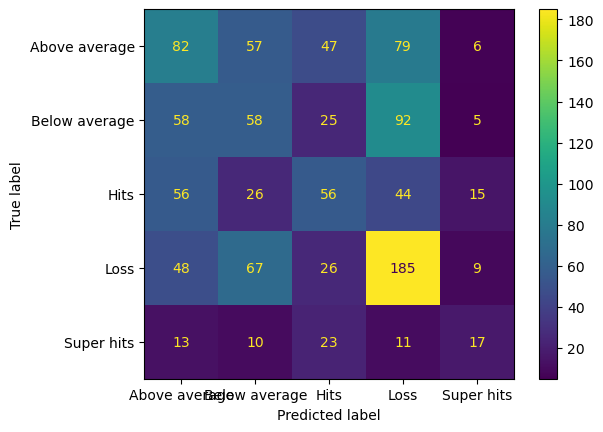

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    dataset[['hit']], test_size = .2, random_state = 10) #split the data

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train.values.ravel())

import xgboost as xgb
clf = xgb.XGBClassifier(enable_categorical = True,  
                      tree_method = "hist")
clf.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = clf.predict(X_test)
y_pred = le.inverse_transform(y_pred)
cm = confusion_matrix(y_test, y_pred)
print("accuracy score: ", accuracy_score(y_test, y_pred))

from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(cm)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = le.inverse_transform(clf.classes_))
disp.plot()
plt.show()